# Digit Recognizer

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [66]:
df_train = pd.read_csv('train.csv', dtype=np.float32)
df_test = pd.read_csv('test.csv', dtype=np.float32)
df_sub = pd.read_csv('sample_submission.csv')

In [67]:
print(df_train.shape, df_test.shape)

(42000, 785) (28000, 784)


### pd -> np

In [68]:
features_numpy = df_train.values[:,1:]/255
targets_numpy = df_train.values[:,0]

In [69]:
print(features_numpy.shape, targets_numpy.shape)

(42000, 784) (42000,)


### split

In [70]:
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy, 
                                                                            targets_numpy,
                                                                            test_size = 0.2,
                                                                            random_state = 42
                                                                           )

In [71]:
print(features_train.shape, features_test.shape, targets_train.shape, targets_test.shape)

(33600, 784) (8400, 784) (33600,) (8400,)


### np -> tensor

In [72]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

In [73]:
print(featuresTrain.shape)

torch.Size([33600, 784])


### tensor -> DataLoader

In [74]:
batch_size = 100
n_iters = 200
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [75]:
train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

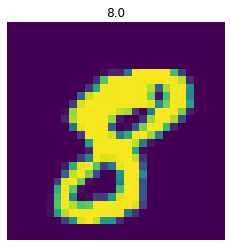

In [76]:
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.show()

In [77]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.fc1(x)
        x1 = self.dropout(x1)
        x2 = self.fc2(x1)
        x2 = self.dropout(x2)
        out = self.fc3(x2)
        
        return out

In [78]:
input_dim = 28 * 28
output_dim = 10

model = LogisticRegressionModel(input_dim, output_dim)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [79]:
count = 0
loss_list = []
iteration_list = []
# 데이터 불러오기
for epoch in range(n_iters):
    for i, (images, labels) in enumerate(train_loader):        
        # 변수정의
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # 기울기 초기화
        optimizer.zero_grad()
        # 순전파
        outputs = model(train)
        # 에러함수 계산
        loss = error(outputs, labels)
        # 기울기 계산
        loss.backward()
        # 파라미터  업데이트
        optimizer.step()
        
#         count += 1
#         #예측
#         if count % 50 == 0:
#             correct = 0
#             total = 0

#             #정확도계산
#             for images,labels in test_loader:
#                 test = Variable(images.view(-1, 28*28))
                
#                 #정답추출
#                 outputs = model(test)
#                 predicted = torch.max(outputs.data, 1)[1]
            
#                 #레이블 길이
#                 total += len(labels)
                
#                 #정답예측 
#                 correct += (predicted == labels).sum()
        
#             #정확도
#             accuracy = 100 * correct / float(total)
#         # loss, iteration 추가
#         loss_list.append(loss.data)
#         iteration_list.append(count)
        
#         if epoch % 10 == 0:
#             print('Iteration: {} Loss: {} Accuracy: {}'.format((epoch), loss.data, accuracy))
    if epoch % 10 == 0:
        print('Iteration: {} Loss: {}'.format((epoch), loss.data))

Iteration: 0 Loss: 2.2226383686065674
Iteration: 10 Loss: 1.0632238388061523
Iteration: 20 Loss: 0.5723592638969421
Iteration: 30 Loss: 0.4263169765472412
Iteration: 40 Loss: 0.331064909696579
Iteration: 50 Loss: 0.2672329545021057
Iteration: 60 Loss: 0.2578798532485962
Iteration: 70 Loss: 0.26590025424957275
Iteration: 80 Loss: 0.22702373564243317
Iteration: 90 Loss: 0.22075515985488892
Iteration: 100 Loss: 0.2382630705833435
Iteration: 110 Loss: 0.19771887362003326
Iteration: 120 Loss: 0.1690441519021988
Iteration: 130 Loss: 0.21965822577476501
Iteration: 140 Loss: 0.22354848682880402
Iteration: 150 Loss: 0.18878750503063202
Iteration: 160 Loss: 0.17116527259349823
Iteration: 170 Loss: 0.2194255292415619
Iteration: 180 Loss: 0.18237408995628357
Iteration: 190 Loss: 0.19237874448299408


In [80]:
submit_numpy = df_test.values/255
test_var = Variable(torch.FloatTensor(submit_numpy), requires_grad=False)

with torch.no_grad():
    test_result = model(test_var)

values, labels = torch.max(test_result, 1)
result = labels.data.numpy()

In [81]:
print(values.shape)
print(labels)

torch.Size([28000])
tensor([2, 0, 9,  ..., 3, 9, 2])


In [82]:
submission = pd.DataFrame({'ImageId':df_sub['ImageId'], 'Label':result})
print(submission.head())
submission.to_csv('submission.csv', index=False)

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
